### 1. Introduction
This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

This Notebook follows three main parts:

* The data preparation
* The CNN modeling and evaluation
* The results prediction and submission

In [1]:
#Import the libraries that are required in this project
import pandas as pd    #For data manipulation, handling tabular data
import numpy as np     #For the mathematical computation
import matplotlib.pyplot as plt   #For visualization of the images
import seaborn as sns  
import matplotlib.image as mpimg       #For reading the images
%matplotlib inline


from sklearn.model_selection import train_test_split   #for splitting the data in to train and test
from sklearn.metrics import confusion_matrix,accuracy_score      #For evaluating the results on the test data
import itertools

from keras.utils.np_utils import to_categorical    #convert in to one hot encoding
from keras.models import Sequential               #Keras api 
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPool2D     #Layers 
from keras.callbacks import ReduceLROnPlateau                #Callbacks to reach the global minima without converging in to the local minima
from keras.preprocessing.image import ImageDataGenerator        #For producing large number of images by rotating,flipping,zooming the images
from keras.optimizers import RMSprop               #Optimizers to reach the global minima


In [2]:
#Unzip the file 
from zipfile import ZipFile
file_name='/content/digit-recognizer.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Data Preparation

In [3]:
#read the data 
df=pd.read_csv('/content/train.csv')
test_set=pd.read_csv('/content/test.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
sns.set(style='white',context='notebook',palette='deep')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


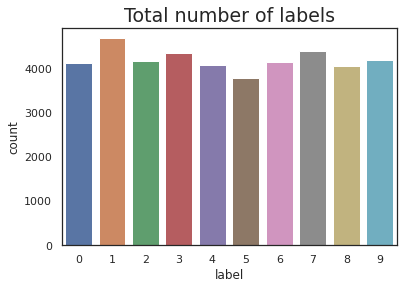

In [5]:
g=sns.countplot(df['label'])
g.set_title('Total number of labels',fontsize=19)
plt.show()

In [6]:
df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [7]:
x=df.drop(columns=['label'],axis=1)
y=df['label']

In [8]:
#Check any missing values are present in the data
print(x.isnull().any().describe())
print(test_set.isnull().any().describe())

count       784
unique        1
top       False
freq        784
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


Hence there is no miising data in the train data , So we can safely go ahead

### Normalization

We perfrom grayscale normalization to reduce the effect of illuminations difference

In [9]:
#Normaize the data
x= x / 255.0
test_set= test_set / 255.0

In [10]:
#Reshape the values i.e., (height=28, width=28 ,canal=1)
x= x.values.reshape(-1,28,28,1)
test_set= test_set.values.reshape(-1,28,28,1)


Train and test images (28,28,1) has stock in to pandas.DataFrame as 1D vecters of 784 values. We reshape all data to 28x28x1 3D vectors

### Label Encoding

In [12]:
#Encode the labels in to one hot vector
y = to_categorical(y,num_classes=10)

### Training and test data set

In [13]:
random_seed=2

In [14]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=random_seed)

We split the data in to train and test with an 0.15% of test data and remaining data is for training.

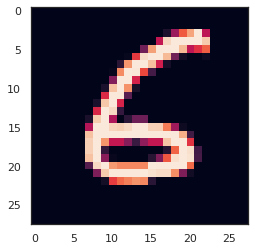

In [19]:
#Sample image from the data
plt.imshow(x_train[0][:,:,0])

## CNN 

### Define the model

I used keras sequantial API, where you have add one layer at a time, starting from the input.


In [21]:
# CNN architeture
#initialize the model with keras api
model= Sequential()
#Adding the input layer and hidden layer
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu',input_shape=(28,28,1)))
#Adding second layer
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',activation='relu'))
#Max pooling layer
model.add(MaxPool2D(pool_size=(2,2)))
#Adding Dropout regularization method  p=0.25
model.add(Dropout(0.25))
#Adding the third hidden layer
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
#Adding forth hidden layer
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
#Add pooling layer
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#dropout layer
model.add(Dropout(0.25))
#Flatten the layer
model.add(Flatten())
#Adding the fully connected layer
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [30]:
#summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

Once our layers has been added to our model, We need to set up the loss function, optimizer , and score function.

we define the loss function to measure the how poorly the model performs on the input images with known labels. It is the error between the observed labels and predicted labels. We use a specific form of categorical classifications (>2 Classes) called the "categorical_crossentrophy".

The important function is optimizer. The function will iteratively improve the parameters (kernel_size,weights, bias,nodes) in order to minimize the loss.

I choosed RMSprop (default values) because it is very effective optimizer. RMSprop update adjust the adagrad method in a very simple way in an attempt to reduce its aggressivness,monotically decreasing the learing rate. We could also used Stocastic gradient descent as it slower than the RMSporop hence we used RMSprop.

In [22]:
#set the optimizer
optimizer=RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-07)

In [35]:
#compile the model

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make an converge faster and to reach the global minima of the loss function, i used learing rate annaler as it helps to meet the global minima faster.

**Note** As much as possible the learning rate should low if the learning rate is too high the steps became larger , converges is also large . As it may leads to the poor accuracy. With high LR, optimizer would fall in to the local minima.

In [24]:
#set a learing rate anelaer
learing_rate=ReduceLROnPlateau(monitor='val_acc',
                               factor=0.5,
                               patience=3,
                               verbose=1,
                               min_lr=0.0001)

### Data augmentation
In order to avoid overfitting, We need to expand the data artifically our hand written digits with the help of centering,zooming,rescale,flipping.



In [28]:
datagen= ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            rotation_range=15,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zca_whitening=False,
                            horizontal_flip=False,
                            vertical_flip=False)

In [29]:
datagen.fit(x_train)

In [37]:
#Fit the model

epochs=10
batch_size=86

history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs,steps_per_epoch=x_train.shape[0] // batch_size,validation_data=(x_test,y_test),callbacks=learing_rate,verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
415/415 - 9s - loss: 0.0627 - accuracy: 0.9818 - val_loss: 0.0287 - val_accuracy: 0.9908
Epoch 2/10
415/415 - 8s - loss: 0.0548 - accuracy: 0.9832 - val_loss: 0.0298 - val_accuracy: 0.9908
Epoch 3/10
415/415 - 8s - loss: 0.0523 - accuracy: 0.9839 - val_loss: 0.0330 - val_accuracy: 0.9906
Epoch 4/10
415/415 - 8s - loss: 0.0495 - accuracy: 0.9850 - val_loss: 0.0267 - val_accuracy: 0.9916
Epoch 5/10
415/415 - 8s - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.0221 - val_accuracy: 0.9925
Epoch 6/10
415/415 - 9s - loss: 0.0450 - accuracy: 0.9872 - val_loss: 0.0230 - val_accuracy: 0.9927
Epoch 7/10
415/415 - 8s - loss: 0.0424 - accuracy: 0.9875 - val_loss: 0.0341 - val_accuracy: 0.9903
Epoch 8/10
415/415 - 8s - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0249 - val_accuracy: 0.9927
Epoch 9/10
415/415 - 8s - loss: 0.0392 - accuracy: 0.9887 - val_loss: 0.0234 - val_accuracy: 0.9930
Epoch 10/10
415/415 - 8s - loss: 0.0389 - accuracy: 0.9886 - val_loss: 0.0204 - val_accuracy: 0.9932

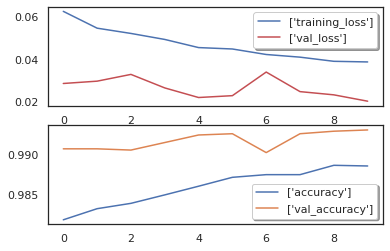

In [40]:
#plot the loss
fig,ax=plt.subplots(2,1)
ax[0].plot(history.history['loss'],label=['training_loss'],color='b')
ax[0].plot(history.history['val_loss'],label=['val_loss'],color='r')
legend = ax[0].legend(loc='best', shadow=True)

#plot the accuracy
ax[1].plot(history.history['accuracy'],label=['accuracy'])
ax[1].plot(history.history['val_accuracy'],label=['val_accuracy'])
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

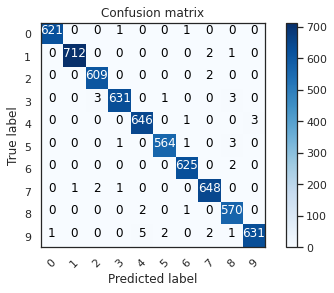

In [41]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Hence we can see our model performs very well , with least possible errors considering the size of the validation dataset plotted by the confusion_matrix.

In [42]:
#Predict the test_data
result=model.predict(test_set)

result = np.argmax(result,axis=1)

results = pd.Series(result,name="Label")